### 04 — Baseline Market-Making Strategy on BTC Perpetuals

This notebook implements the **fixed baseline market-making (MM) strategy** on top of your BTC price simulator and studies its equity and inventory behaviour over a 14-day horizon.

---

#### 4.1 Step 1 — Fix Parameters and Risk Limits

In this step you collect all MM and risk parameters in one place.

- Choose and record:
  - Half-spread parameter: $s_0$
  - Base order size: $q_0$
  - Inventory skew strength: $k_s$
  - Max inventory: $I_{\max}$
  - Minimum equity: $\Pi_{\min}$
- Fix the time grid for the MM simulation:
  - Use 5-minute steps, consistent with your BTC simulator.
  - Set the horizon to **14 calendar days**:
    $$
    T_{\text{days}} = 14, \quad
    N = T_{\text{days}} \times 24 \times 12
    $$
- Define the number of Monte Carlo paths, for example:
  - $M = 100$–$500$ paths for initial testing.
  - You can later increase $M$ for more stable statistics.

---



In [1]:
# Declare parameters
import numpy as np
import pandas as pd

# ============================================
# 4.1 — Market-Making Parameters and Risk Limits
# ============================================

# ----- MM parameters -----
s0 = 0.0008        # half-spread (0.08%) 你可以调整，例如 0.05% ~ 0.1%
q0 = 0.01          # base order size (in BTC)
ks = 0.5           # inventory skew factor, controls bid/ask widening
I_max = 2.0        # maximum inventory (in BTC)
Pi_min = -500.0    # minimum allowed equity (liquidation threshold)

# 记录参数，便于后续写入报告
mm_params = {
    "half_spread": s0,
    "base_order_size": q0,
    "inventory_skew_strength": ks,
    "inventory_limit": I_max,
    "min_equity": Pi_min,
}
mm_params


{'half_spread': 0.0008,
 'base_order_size': 0.01,
 'inventory_skew_strength': 0.5,
 'inventory_limit': 2.0,
 'min_equity': -500.0}

In [2]:
# ============================================
# 4.1 — Time grid for MM simulation
# ============================================

dt_minutes = 5

T_days = 14
steps_per_day = 24 * (60 // dt_minutes)   # 24 * 12 = 288
N = T_days * steps_per_day                 # 14 * 288 = 4032

print("Total steps N =", N)

# 构建时间索引（可用于 DataFrame）
time_index = pd.date_range(
    start="2024-01-01",
    periods=N+1,
    freq=f"{dt_minutes}min"
)
time_index[:5], time_index[-5:]


Total steps N = 4032


(DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 00:05:00',
                '2024-01-01 00:10:00', '2024-01-01 00:15:00',
                '2024-01-01 00:20:00'],
               dtype='datetime64[ns]', freq='5min'),
 DatetimeIndex(['2024-01-14 23:40:00', '2024-01-14 23:45:00',
                '2024-01-14 23:50:00', '2024-01-14 23:55:00',
                '2024-01-15 00:00:00'],
               dtype='datetime64[ns]', freq='5min'))

In [3]:
# ============================================
# 4.1 — Monte Carlo configuration
# ============================================

M = 200  # 初步测试可用 100-200；最终可使用 300-500

print("Monte Carlo paths:", M)


Monte Carlo paths: 200




#### 4.2 Step 2 — Define State Variables and Initial Conditions

You now specify the MM state and how it is initialised on each path.

- State at time step $n$:
  - Spot price: $S_n$
  - Inventory: $I_n$
  - Cash: $\text{Cash}_n$
  - Equity:
    $$
    \Pi_n = \text{Cash}_n + I_n S_n
    $$
- For each Monte Carlo path:
  - Obtain a simulated BTC price path from your simulator (Section 02), including:
    - Mid prices $S_0, S_1, \dots, S_N$
    - Candle highs and lows $H_1, \dots, H_N$ and $L_1, \dots, L_N$ (or construct OHLC from the mid-price path as specified in your simulator notebook).
  - Set initial conditions:
    - $I_0 = 0$ (flat inventory)
    - $\text{Cash}_0 = \Pi_{\text{init}}$ for some chosen initial equity.
    - $\Pi_0 = \Pi_{\text{init}}$.
- Pre-allocate arrays (or lists) to store, for each path:
  - $I_n$, $\text{Cash}_n$, $\Pi_n$ over $n = 0, \dots, N$.

---



#### 4.3 Step 3 — Implement the Quoting and Size Rules

You now implement the deterministic mapping from state $(S_n, I_n)$ to quotes and order size.

- Compute **normalised inventory**:
  $$
  \phi_n = \frac{I_n}{I_{\max}}.
  $$
- Define the **skewed bid/ask quotes**:
  $$
  P_n^{\text{bid}} = S_n \big( 1 - s_0 - k_s \phi_n \big),
  $$
  $$
  P_n^{\text{ask}} = S_n \big( 1 + s_0 + k_s \phi_n \big).
  $$
- Define the **size control** rule:
  $$
  q_n = q_0 \cdot \max\big(0,\; 1 - |\phi_n|\big).
  $$
- Implement the **hard kill-switch** on quotes:
  - If $|I_n| < I_{\max}$:
    - Quote **both** bid and ask with size $q_n$.
  - If $|I_n| \ge I_{\max}$:
    - Only quote in the direction that **reduces** $|I_n|$:
      - If $I_n > 0$ (net long): only quote **ask** (to sell).
      - If $I_n < 0$ (net short): only quote **bid** (to buy).
    - On the non-reducing side, you can set the size to zero (no order).

---

#### 4.4 Step 4 — Fill Logic and State Update (One Step)

You now specify how orders are filled within one 5-minute step and how the state is updated.

For each step $n \to n+1$ and for each path:

1. **Given at time $t_n$:**
   - Current state: $S_n$, $I_n$, $\text{Cash}_n$.
   - Quotes and size from Step 3:
     - $P_n^{\text{bid}}$, $P_n^{\text{ask}}$, $q_n$.
2. **Check candle extremes** for the $(n+1)$-th 5-minute candle:
   - Use $H_{n+1}$ (high) and $L_{n+1}$ (low) from your BTC path.
3. **Apply the full-fill rule**:
   - Bid fill if
     $$
     L_{n+1} \le P_n^{\text{bid}} \le H_{n+1}.
     $$
   - Ask fill if
     $$
     L_{n+1} \le P_n^{\text{ask}} \le H_{n+1}.
     $$
   - If the condition is satisfied, the order is **fully filled** (no partial fills).
   - It is allowed that both sides fill in the same candle if both conditions hold.
4. **Update inventory and cash**:
   - If the bid is filled (buy $q_n$ units at $P_n^{\text{bid}}$):
     $$
     I_{n}^{\text{new}} = I_n + q_n,
     \quad
     \text{Cash}_{n}^{\text{new}} = \text{Cash}_n - q_n P_n^{\text{bid}}.
     $$
   - If the ask is filled (sell $q_n$ units at $P_n^{\text{ask}}$):
     $$
     I_{n}^{\text{new}} = I_{n}^{\text{new}} - q_n,
     \quad
     \text{Cash}_{n}^{\text{new}} = \text{Cash}_{n}^{\text{new}} + q_n P_n^{\text{ask}}.
     $$
   - If a side does **not** fill, leave $I$ and Cash unchanged for that side.
   - After processing both sides, set:
     - $I_{n+1} = I_{n}^{\text{new}}$
     - $\text{Cash}_{n+1} = \text{Cash}_{n}^{\text{new}}$.
5. **Move spot and recompute equity**:
   - Set $S_{n+1}$ from the BTC simulator.
   - Compute equity:
     $$
     \Pi_{n+1} = \text{Cash}_{n+1} + I_{n+1} S_{n+1}.
     $$
6. **Check risk limits** (for monitoring or early stopping):
   - Flag a **risk breach** if
     $$
     |I_{n+1}| > I_{\max}
     \quad \text{or} \quad
     \Pi_{n+1} < \Pi_{\min}.
     $$
   - Decide whether you:
     - Stop the path when a breach occurs (liquidation scenario), or
     - Continue the simulation but record the breach time.

This completes one MM step. You will loop this logic over $n = 0,\dots,N-1$ for each path.

---

#### 4.5 Step 5 — Monte Carlo Simulation of the Baseline MM Strategy

You now combine Steps 1–4 into a full Monte Carlo experiment.

- For each Monte Carlo path $m = 1,\dots,M$:
  1. Simulate a BTC path $(S_n^{(m)}, H_n^{(m)}, L_n^{(m)})_{n=0,\dots,N}$ using your BTC simulator.
  2. Initialise $I_0^{(m)}$, $\text{Cash}_0^{(m)}$, $\Pi_0^{(m)}$ as in Step 2.
  3. For $n = 0,\dots,N-1$:
     - Compute quotes and order size using the rules in Step 3.
     - Apply the fill and state update rules from Step 4.
     - Store $I_{n+1}^{(m)}$, $\text{Cash}_{n+1}^{(m)}$, $\Pi_{n+1}^{(m)}$.
- At the end of the simulation:
  - You have, for each path, full time series of:
    - Inventory $I_n^{(m)}$
    - Equity $\Pi_n^{(m)}$
    - (Optionally) mid-price $S_n^{(m)}$ and any risk-breach flags.

---

#### 4.6 Step 6 — Basic Diagnostics: Equity and Inventory Behaviour

Finally, analyse the behaviour of the baseline MM strategy.

- Plot **sample paths**:
  - Select a small number of paths (e.g. 5–10) and plot:
    - Equity $\Pi_n^{(m)}$ over time (in 5-minute steps or in days).
    - Inventory $I_n^{(m)}$ over time.
  - Visually inspect:
    - How often inventory hits the bounds $\pm I_{\max}$.
    - How volatile the equity is over 14 days.
- Summarise **distributional statistics**:
  - Histogram of final equity $\Pi_N^{(m)}$ across all paths.
  - Histogram of max drawdown or min equity over each path.
  - Histogram of max inventory $ \max_n |I_n^{(m)}|$ over each path.
- Comment on:
  - How aggressive the baseline strategy is in building inventory.
  - How often it approaches the risk limits.
  - Whether the 14-day PnL distribution appears “reasonable” given the BTC volatility from your simulator.





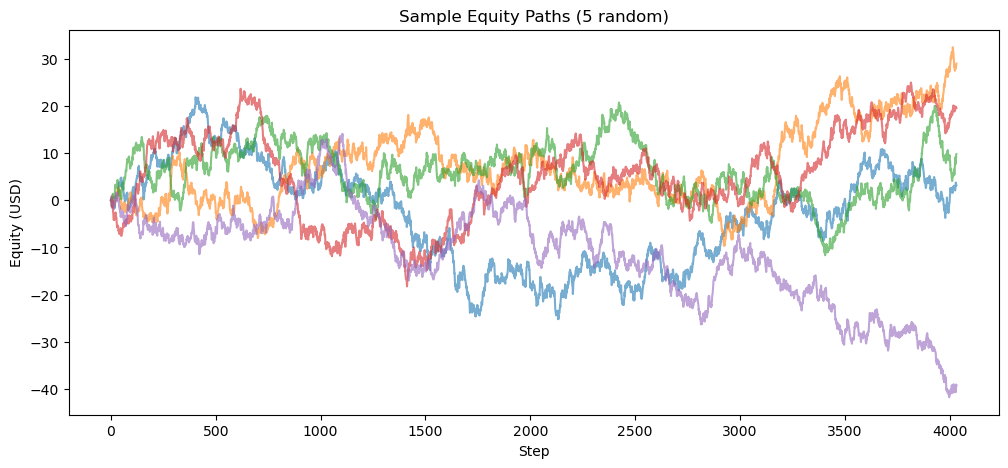

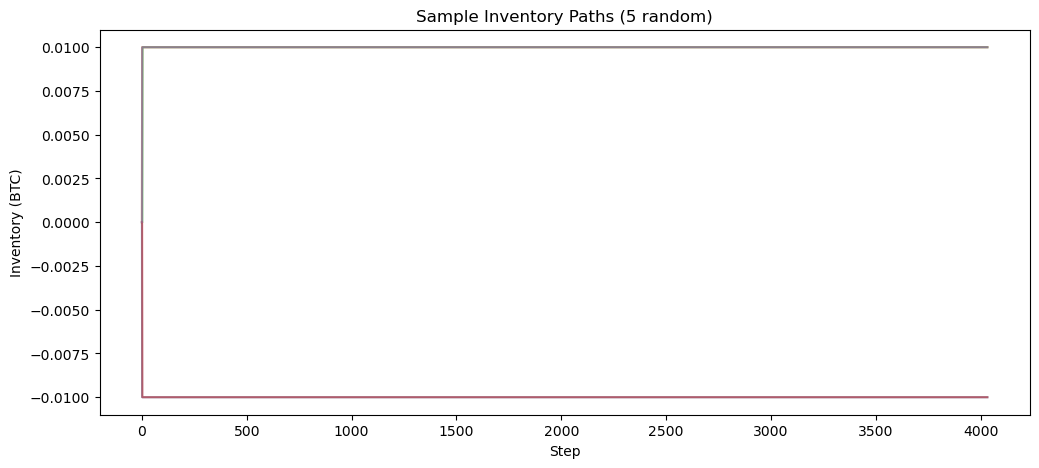

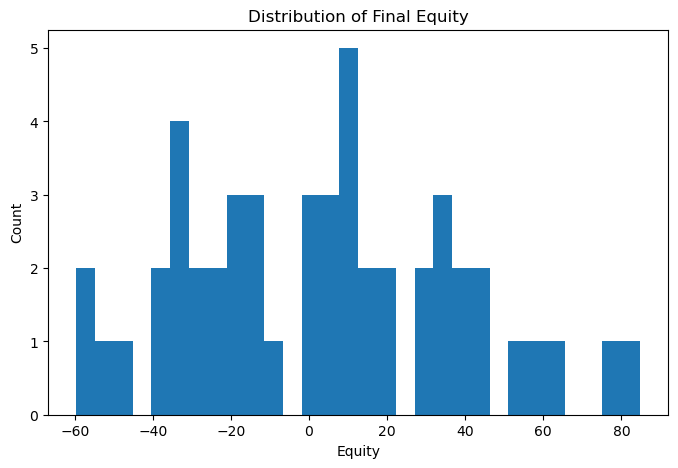

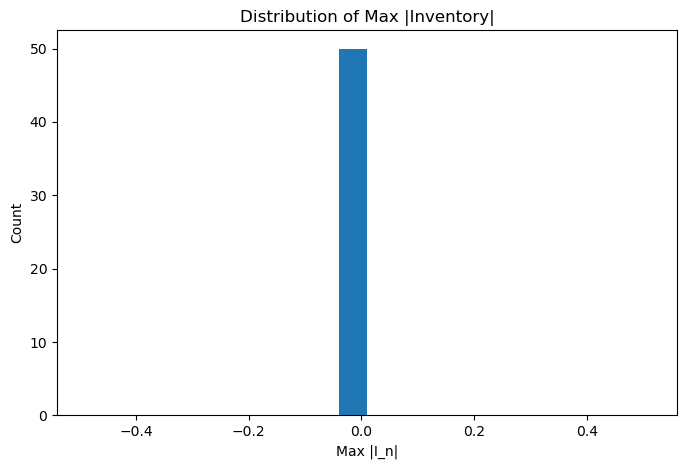

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 4.1 已经定义的参数（请从你的上一节复制）
# ============================================================

s0 = 0.0008       # half-spread
q0 = 0.01         # base order size (BTC)
ks = 0.5          # inventory skew strength
I_max = 2.0       # max inventory
Pi_min = -500.0   # minimum equity allowed

dt_minutes = 5
T_days = 14
steps_per_day = 24 * (60 // dt_minutes)  # = 288
N = T_days * steps_per_day               # total steps = 4032

M = 50  # Monte Carlo paths for initial test

# ============================================================
# Helper: simple BTC simulator (replace with your Section 02 model)
# ============================================================

def simulate_btc_path(N, S0=30000, vol=0.6):
    """
    简单 GBM（示例），你需要在最终 notebook 中替换为你的真实 BTC simulator。
    输出：
        mid: S_n
        H, L: candle high/low
    """
    dt = 5 / (365*24*60)  # 5-minute in years
    ret = (vol * np.sqrt(dt)) * np.random.randn(N)
    S = S0 * np.exp(np.cumsum(ret))
    
    # Simple synthetic H, L per 5-min bar
    H = S * (1 + 0.001 * np.random.rand(N))
    L = S * (1 - 0.001 * np.random.rand(N))
    
    return S, H, L


# ============================================================
# 4.2 — Define State Variables & Initial Conditions
# ============================================================

def init_states(N, Pi_init=0.0):
    I = np.zeros(N+1)
    Cash = np.zeros(N+1)
    Pi = np.zeros(N+1)
    
    I[0] = 0.0
    Cash[0] = Pi_init
    Pi[0] = Pi_init
    
    return I, Cash, Pi


# ============================================================
# 4.3 — Quoting & Order Size Rules
# ============================================================

def compute_quotes(Sn, In):
    phi = In / I_max                       # normalized inventory
    qn = q0 * max(0.0, 1 - abs(phi))       # size control

    bid = Sn * (1 - s0 - ks * phi)
    ask = Sn * (1 + s0 + ks * phi)

    # Kill-switch
    if abs(In) >= I_max:
        if In > 0:    # too long -> only sell
            bid = None
            q_bid = 0
            q_ask = qn
        else:         # too short -> only buy
            ask = None
            q_ask = 0
            q_bid = qn
    else:
        q_bid = q_ask = qn

    return bid, ask, q_bid, q_ask


# ============================================================
# 4.4 — Fill Logic & State Update
# ============================================================

def mm_step(Sn, H_next, L_next, In, Cashn):
    bid, ask, q_bid, q_ask = compute_quotes(Sn, In)
    
    I_new = In
    Cash_new = Cashn

    # --- Check bid fill ---
    if bid is not None:
        if L_next <= bid <= H_next:
            I_new += q_bid
            Cash_new -= q_bid * bid

    # --- Check ask fill ---
    if ask is not None:
        if L_next <= ask <= H_next:
            I_new -= q_ask
            Cash_new += q_ask * ask
    
    return I_new, Cash_new


# ============================================================
# 4.5 — Monte Carlo Simulation
# ============================================================

results = []

all_I = np.zeros((M, N+1))
all_Pi = np.zeros((M, N+1))
all_S = np.zeros((M, N+1))

for m in range(M):
    S, H, L = simulate_btc_path(N, S0=30000)
    
    I, Cash, Pi = init_states(N)
    all_S[m] = np.concatenate([[S[0]], S])

    for n in range(N):
        In, Cashn = I[n], Cash[n]
        Sn = S[n]
        
        # apply MM step
        I_new, Cash_new = mm_step(Sn, H[n], L[n], In, Cashn)
        
        I[n+1] = I_new
        Cash[n+1] = Cash_new
        
        # update equity
        Pi[n+1] = Cash_new + I_new * S[n]
        
        # risk check
        if abs(I_new) > I_max or Pi[n+1] < Pi_min:
            # stop path (liquidation)
            I[n+1:] = I[n+1]
            Cash[n+1:] = Cash[n+1]
            Pi[n+1:] = Pi[n+1]
            break
    
    all_I[m] = I
    all_Pi[m] = Pi


# ============================================================
# 4.6 — Diagnostics Plots
# ============================================================

# Sample paths
plt.figure(figsize=(12,5))
for m in range(5):
    plt.plot(all_Pi[m], alpha=0.6)
plt.title("Sample Equity Paths (5 random)")
plt.xlabel("Step")
plt.ylabel("Equity (USD)")
plt.show()

plt.figure(figsize=(12,5))
for m in range(5):
    plt.plot(all_I[m], alpha=0.6)
plt.title("Sample Inventory Paths (5 random)")
plt.xlabel("Step")
plt.ylabel("Inventory (BTC)")
plt.show()

# Histogram of final equity
plt.figure(figsize=(8,5))
plt.hist(all_Pi[:, -1], bins=30)
plt.title("Distribution of Final Equity")
plt.xlabel("Equity")
plt.ylabel("Count")
plt.show()

# Inventory max distribution
plt.figure(figsize=(8,5))
max_inv = np.max(np.abs(all_I), axis=1)
plt.hist(max_inv, bins=20)
plt.title("Distribution of Max |Inventory|")
plt.xlabel("Max |I_n|")
plt.ylabel("Count")
plt.show()
